### Confusion matrix functions...

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from data_prep import DermNet, get_dataloaders

# Reference: https://gist.github.com/josephyooo/560130e1977c64e8e615ff133b457755
def calculate_confusion_matrix(model, dataloader, device, num_classes):
    matrix = np.zeros((num_classes, num_classes))

    model.eval()
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            pred_labels = torch.argmax(outputs, axis=1)

            for i in range(labels.shape[0]):
                    matrix[labels[i], pred_labels[i]] += 1


    matrix = matrix / matrix.sum(axis=1, keepdims=True)

    return matrix

def display_confusion_matrix(confusion_matrix, num_classes, instance, class_names=None, log_scale=False):
    fig, ax = plt.subplots()

    ax.set_title(f'Confusion Matrix for {instance}')
    fig.set_size_inches(10, 6)

    if log_scale:
        cax = ax.matshow(confusion_matrix)
    else:
        import copy
        import matplotlib
        my_cmap = copy.copy(matplotlib.colormaps['grey']) # copy the default cmap
        my_cmap.set_bad((0,0,0))
        cax = ax.matshow(confusion_matrix, norm=matplotlib.colors.LogNorm(), interpolation='nearest', cmap=my_cmap)

    cbar = fig.colorbar(cax)

    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_xticks(np.arange(num_classes))
    ax.set_yticks(np.arange(num_classes))
    if class_names:
        ax.set_xticklabels(class_names)
        ax.set_yticklabels(class_names)
    ax.xaxis.set_ticks_position('bottom')

    for (i, j), z in np.ndenumerate(confusion_matrix):
        ax.text(j, i, '{:0.3f}'.format(z), ha='center', va='center')

    # plt.savefig('confusion_matrix.png')
    plt.show()

# required to get the same dataset split as in training
torch.manual_seed(0)

def get_model_confusion_matrix(model, mode):
    """
    mode: 'ft' or 'ffe'
    """
    # setup data and model
    dataset = DermNet()
    num_classes = len(dataset.classes)
    # dataloader, _ = get_dataloaders(dataset=dataset, split=0, shuffle=False)
    _, dataloader = get_dataloaders(dataset=dataset)

    # get and set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    ffe = True if mode == 'ffe' else False
    model = model(device, num_classes, ffe)

    # infer weights file name from model class name
    model.load_state_dict(torch.load(f'weights/{model.__class__.__name__}_{mode}.pt'))

    # calculate and display confusion matrix
    class_names = dataset.classes
    class_names = [class_names[x][:-9] for x in range(num_classes)]

    confusion_matrix = calculate_confusion_matrix(model, dataloader, device, num_classes)
    display_confusion_matrix(confusion_matrix, num_classes, instance=f'{model.__class__.__name__}_{mode}', class_names=class_names, log_scale=True)

### Make confusion matrix for each 'instance' (model and mode)

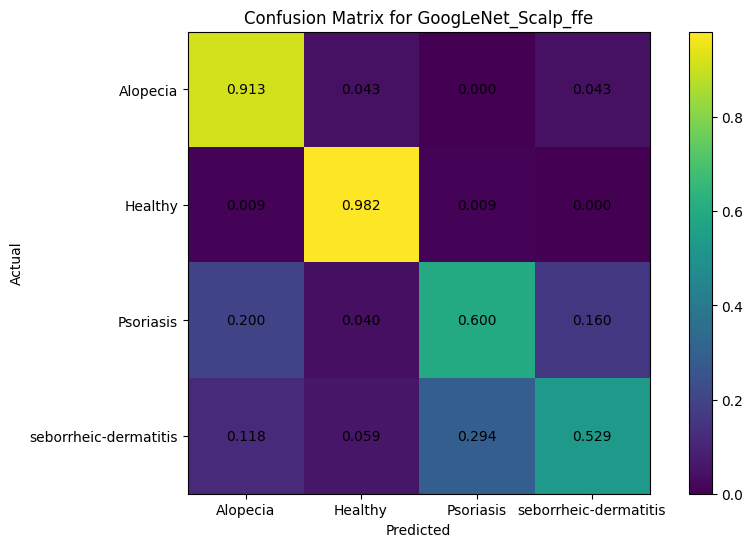

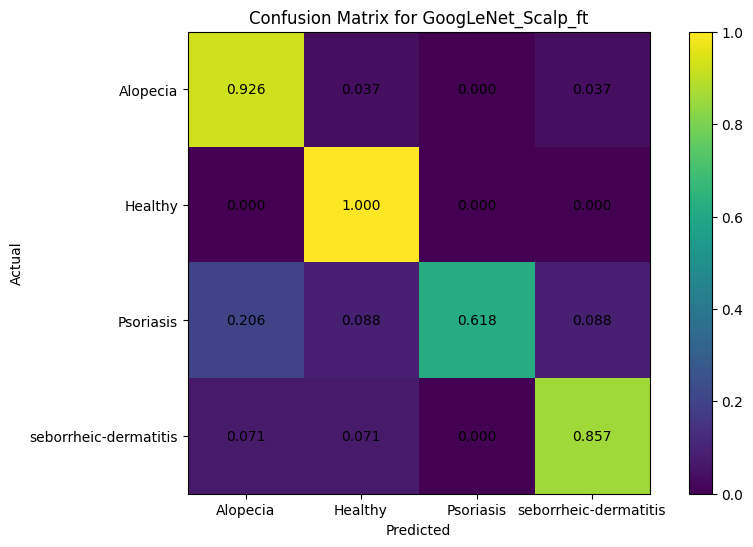

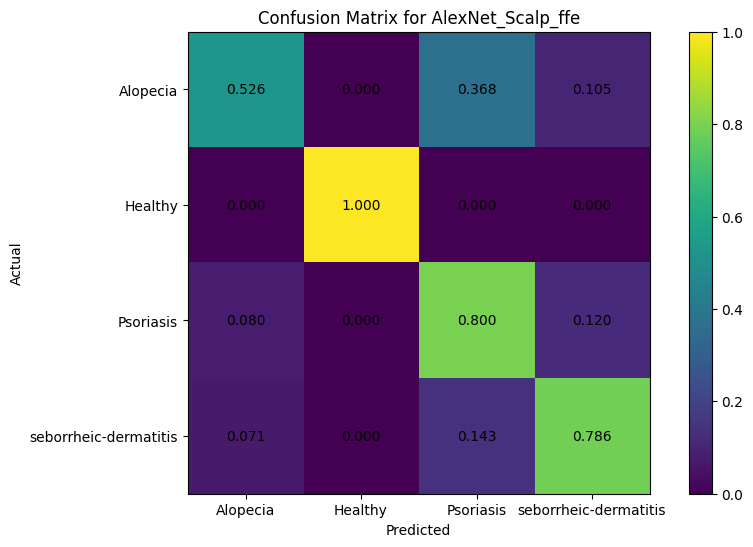

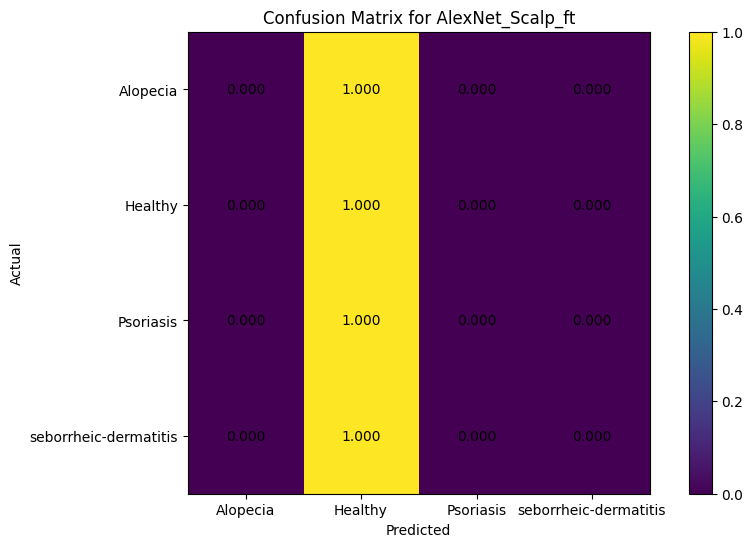

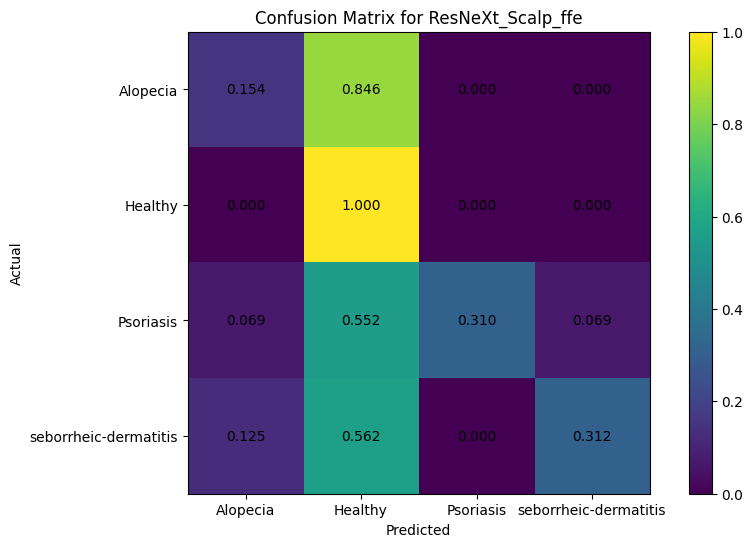

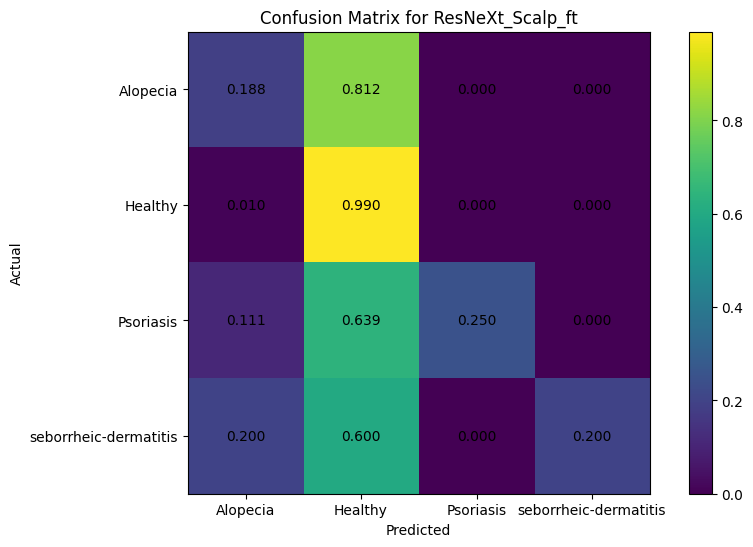

In [2]:
from models import GoogLeNet_Scalp, AlexNet_Scalp, ResNeXt_Scalp

models = [GoogLeNet_Scalp, AlexNet_Scalp, ResNeXt_Scalp]
modes = ['ffe', 'ft']

for model in models:
    for mode in modes:
        get_model_confusion_matrix(model, mode)

### Plot losses and accuracies against epochs for each 'instance'

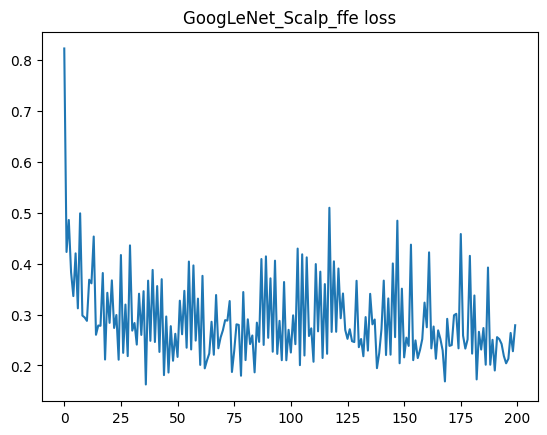

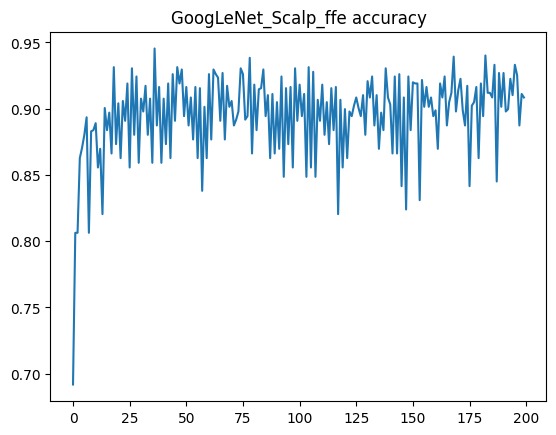

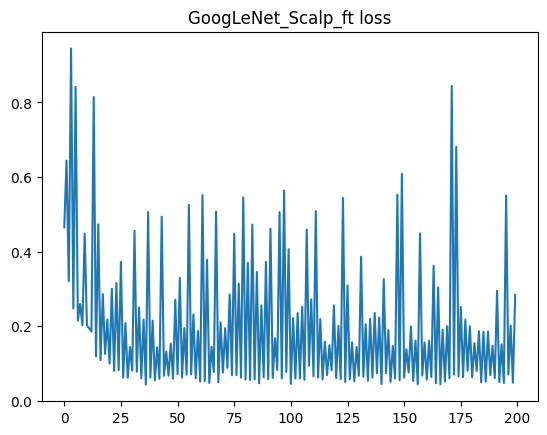

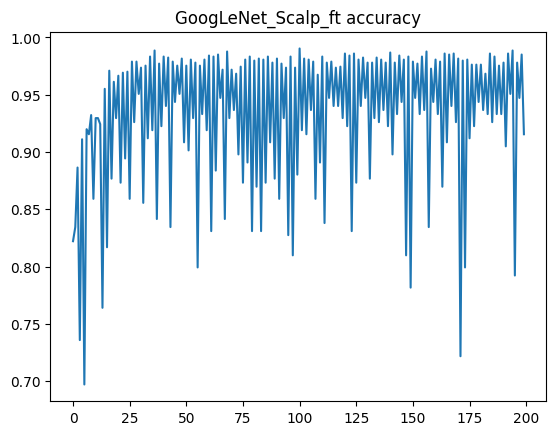

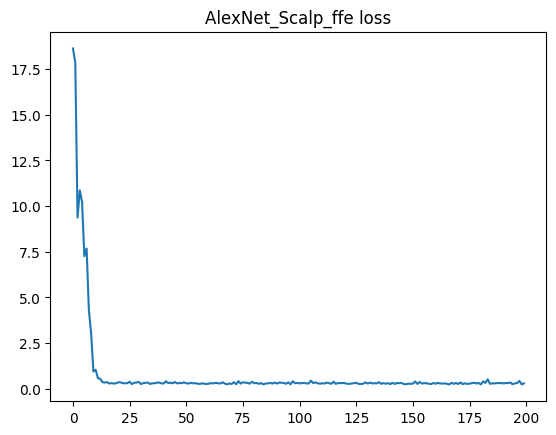

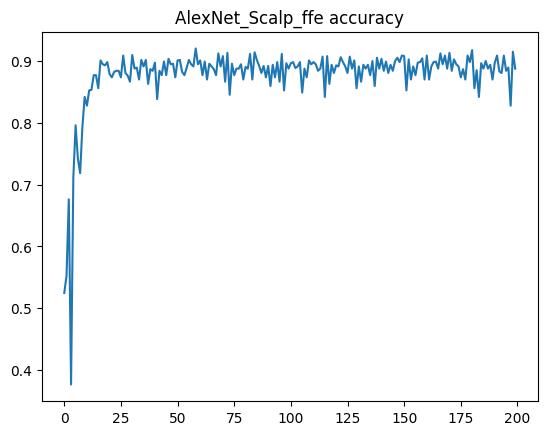

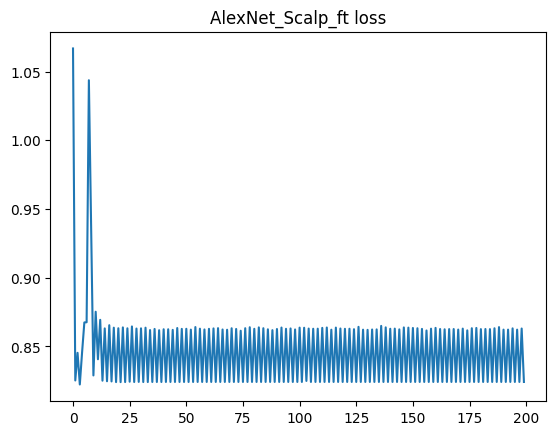

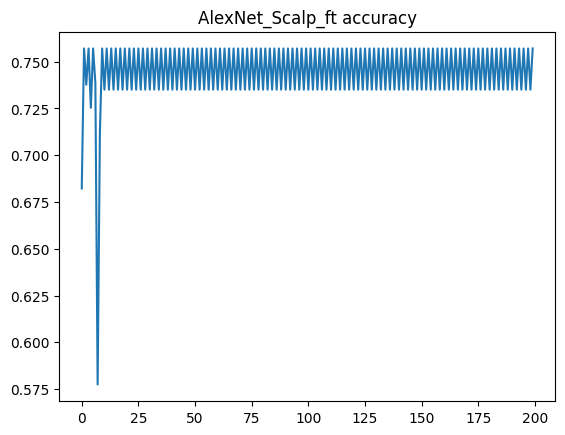

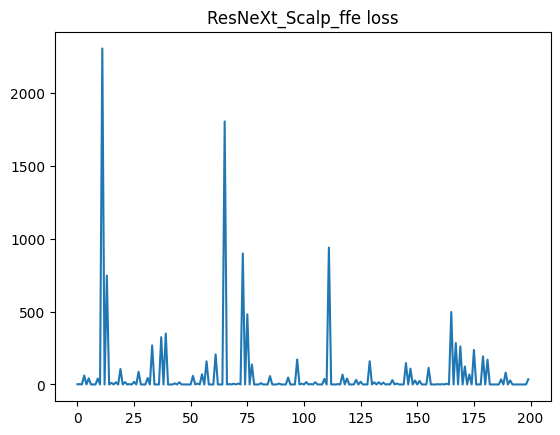

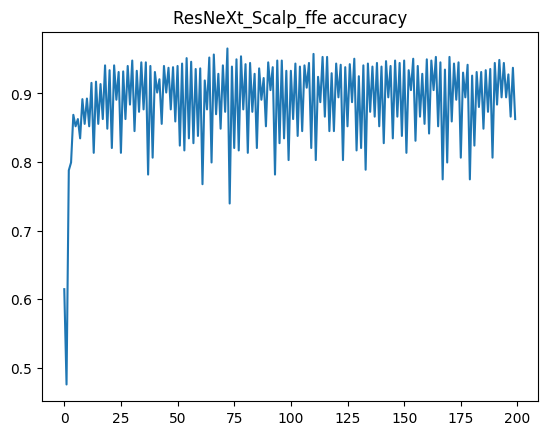

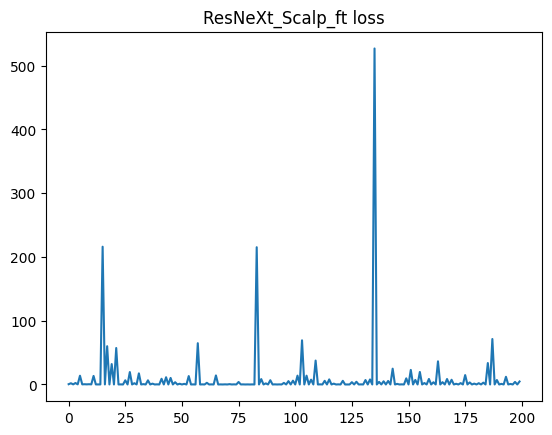

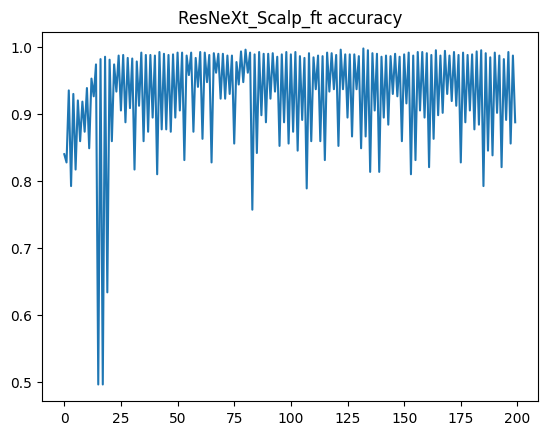

In [3]:
models = ['GoogLeNet_Scalp', 'AlexNet_Scalp', 'ResNeXt_Scalp']
modes = ['ffe', 'ft']

for model in models:
    for mode in modes:
        losses = torch.load(f'weights/{model}_{mode}_losses.pt')

        plt.title(f'{model}_{mode} loss')
        plt.plot(range(len(losses)), losses)
        plt.show()

        accuracies = torch.load(f'weights/{model}_{mode}_accuracies.pt')
        accuracies = [x.item() for x in accuracies]

        plt.title(f'{model}_{mode} accuracy')
        plt.plot(range(len(accuracies)), accuracies)
        plt.show()
